In [2]:
import os
import h5py
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
from imutils import paths
import matplotlib.pyplot as plt
from matplotlib.figure import Figure
import matplotlib.axes._axes as axes
sns.set()

In [5]:
# import the necessary packages
from sklearn.preprocessing import LabelBinarizer, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from loader_util.preprocessing import ImageToArrayPreprocessor, \
    AspectAwarePreprocessor, MeanSubtractionPreProcessor, SimplePreProcessor
from loader_util.datasets import SimpleDatasetLoader
from loader_util.io import HDF5DatasetGenerator
from loader_util.nn.conv import FCHeadNet, LeNet, AlexNet
from loader_util.callbacks import TrainingMonitor, EpochCheckpoint
##
from tensorflow.keras.layers import Conv2D, Activation, Flatten, Dense
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import RMSprop, SGD, Adam
from tensorflow.keras.applications import VGG16, ResNet50
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model, load_model, save_model
from tensorflow.keras import backend as K
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import LearningRateScheduler

In [6]:
# construct the train image generator
aug = ImageDataGenerator(rotation_range=20,
                         zoom_range=0.15,
                         width_shift_range=0.2,
                         height_shift_range=0.2,
                         shear_range=0.15,
                         horizontal_flip=True,
                         fill_mode='nearest')

In [7]:
batch_size = 64
epoch_num = 300

# initialise the image preprocessors
sp = SimplePreProcessor(width=28, height=28)
iap = ImageToArrayPreprocessor()

In [9]:
# initialise the data paths

dbBase = r"/home/mhasan3/Desktop/WorkFolder/CAD_Data_Repo/"
dbTrainPath = f"{dbBase}//train_threshinv_5classNLP_28px1px_255div.hdf5"
dbValidPath = f"{dbBase}//validate_threshinv_5classNLP_28px1px_255div.hdf5"

# get the no. of classes
trainFile = h5py.File(name=dbTrainPath, mode="r")
class_num = len(list(np.unique(trainFile["labels"])))
print(f"Total no. of classes in dataset: {class_num}")

# get unique labels
label_names = list(trainFile["label_names"])
label_names = [label.decode() for label in label_names]
print(f"Unique Labels: {label_names}")

Total no. of classes in dataset: 5
Unique Labels: ['Bearings', 'Bolts', 'Collets', 'Springs', 'Sprockets']


In [10]:
##### consider class weight discrepency
le = LabelEncoder()
labels = le.fit_transform(trainFile["labels"])
encoded_labels = to_categorical(labels)

classLabels = le.classes_
classTotals = encoded_labels.sum(axis=0) # type: np.ndarray
classWeight = classTotals.max() / classTotals

print(f"ClassLabels: {classLabels}")
print(f"ClassWeights: {classWeight}")

ClassLabels: [0 1 2 3 4]
ClassWeights: [1.0111234 1.0545243 1.        1.1277915 1.6378379]


In [11]:
# initialise the train and valid generators
trainGen = HDF5DatasetGenerator(dbPath=dbTrainPath,
                                batchSize=batch_size,
                                preprocessors=[sp, iap],
                                classes=class_num,
                                aug=aug)

valGen = HDF5DatasetGenerator(dbPath=dbValidPath,
                              batchSize=batch_size,
                              preprocessors=[sp, iap],
                              classes=class_num)

In [12]:
# define the Learning Rate Scheduler

initial_rate = 5e-3

def poly_decay(epoch):
    max_epochs = epoch_num
    baseLR = initial_rate
    power = 1.0
    
    alpha = baseLR * (1 - (epoch / float(max_epochs))) ** power
    return alpha

In [13]:
#model = AlexNet.build(width=80, height=80, depth=3, classes=class_num)
model = LeNet.build(width=28,
                    height=28,
                    depth=1,
                    classes=class_num)

Instructions for updating:
Colocations handled automatically by placer.


In [14]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 20)        520       
_________________________________________________________________
activation (Activation)      (None, 28, 28, 20)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 20)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 50)        25050     
_________________________________________________________________
activation_1 (Activation)    (None, 14, 14, 50)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 50)          0         
_________________________________________________________________
flatten (Flatten)            (None, 2450)              0         
__________

In [15]:
# compile and optimise model
opt = SGD(lr=initial_rate)
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

# construct callbacks
path = os.path.sep.join([dbBase, f'{os.getpid()}.png'])
callbacks = [TrainingMonitor(path),
             LearningRateScheduler(poly_decay),]
             #EpochCheckpoint(outputPath=dbBase)]

In [16]:
# train the head for few epochs
H = model.fit_generator(
    trainGen.generator(),
    steps_per_epoch=trainGen.numImages//batch_size,
    validation_data=valGen.generator(),
    validation_steps=valGen.numImages//batch_size,
    epochs=epoch_num,
    max_queue_size=10,
    verbose=1,
    callbacks=callbacks,
    class_weight=classWeight
)

Instructions for updating:
Use tf.cast instead.
Epoch 1/300
62/62 [==============================] - 3s 46ms/step - loss: 1.5582 - acc: 0.3173 - val_loss: 1.4754 - val_acc: 0.3385
Epoch 2/300
62/62 [==============================] - 1s 19ms/step - loss: 1.4453 - acc: 0.3990 - val_loss: 1.2686 - val_acc: 0.5758
Epoch 3/300
62/62 [==============================] - 1s 19ms/step - loss: 1.2544 - acc: 0.5732 - val_loss: 0.9307 - val_acc: 0.6620
Epoch 4/300
62/62 [==============================] - 1s 17ms/step - loss: 1.0120 - acc: 0.6554 - val_loss: 0.7008 - val_acc: 0.7228
Epoch 5/300
62/62 [==============================] - 1s 19ms/step - loss: 0.9116 - acc: 0.6718 - val_loss: 0.5687 - val_acc: 0.8872
Epoch 6/300
62/62 [==============================] - 1s 18ms/step - loss: 0.8500 - acc: 0.6834 - val_loss: 0.5629 - val_acc: 0.8391
Epoch 7/300
62/62 [==============================] - 1s 19ms/step - loss: 0.8035 - acc: 0.7023 - val_loss: 0.4671 - val_acc: 0.8854
Epoch 8/300
62/62 [=========

Epoch 38/300
62/62 [==============================] - 1s 21ms/step - loss: 0.3583 - acc: 0.8830 - val_loss: 0.2306 - val_acc: 0.9323
Epoch 39/300
62/62 [==============================] - 1s 20ms/step - loss: 0.3443 - acc: 0.8881 - val_loss: 0.2095 - val_acc: 0.9497
Epoch 40/300
62/62 [==============================] - 1s 21ms/step - loss: 0.3446 - acc: 0.8858 - val_loss: 0.1797 - val_acc: 0.9485
Epoch 41/300
62/62 [==============================] - 1s 20ms/step - loss: 0.3475 - acc: 0.8848 - val_loss: 0.1770 - val_acc: 0.9502
Epoch 42/300
62/62 [==============================] - 1s 19ms/step - loss: 0.3431 - acc: 0.8858 - val_loss: 0.1659 - val_acc: 0.9566
Epoch 43/300
62/62 [==============================] - 1s 19ms/step - loss: 0.3338 - acc: 0.8916 - val_loss: 0.1972 - val_acc: 0.9271
Epoch 44/300
62/62 [==============================] - 1s 19ms/step - loss: 0.3378 - acc: 0.8903 - val_loss: 0.1893 - val_acc: 0.9485
Epoch 45/300
62/62 [==============================] - 1s 23ms/step - 

62/62 [==============================] - 1s 19ms/step - loss: 0.2525 - acc: 0.9158 - val_loss: 0.1319 - val_acc: 0.9635
Epoch 77/300
62/62 [==============================] - 1s 20ms/step - loss: 0.2396 - acc: 0.9249 - val_loss: 0.1306 - val_acc: 0.9630
Epoch 78/300
62/62 [==============================] - 1s 21ms/step - loss: 0.2469 - acc: 0.9191 - val_loss: 0.1217 - val_acc: 0.9705
Epoch 79/300
62/62 [==============================] - 1s 21ms/step - loss: 0.2464 - acc: 0.9198 - val_loss: 0.1413 - val_acc: 0.9688
Epoch 80/300
62/62 [==============================] - 1s 20ms/step - loss: 0.2606 - acc: 0.9108 - val_loss: 0.1657 - val_acc: 0.9566
Epoch 81/300
62/62 [==============================] - 1s 20ms/step - loss: 0.2462 - acc: 0.9211 - val_loss: 0.1282 - val_acc: 0.9566
Epoch 82/300
62/62 [==============================] - 2s 27ms/step - loss: 0.2462 - acc: 0.9181 - val_loss: 0.1154 - val_acc: 0.9659
Epoch 83/300
62/62 [==============================] - 1s 19ms/step - loss: 0.2288 

62/62 [==============================] - 1s 20ms/step - loss: 0.2083 - acc: 0.9297 - val_loss: 0.0998 - val_acc: 0.9688
Epoch 115/300
62/62 [==============================] - 1s 21ms/step - loss: 0.1946 - acc: 0.9392 - val_loss: 0.0983 - val_acc: 0.9734
Epoch 116/300
62/62 [==============================] - 1s 21ms/step - loss: 0.1999 - acc: 0.9319 - val_loss: 0.1088 - val_acc: 0.9711
Epoch 117/300
62/62 [==============================] - 1s 21ms/step - loss: 0.1957 - acc: 0.9347 - val_loss: 0.0973 - val_acc: 0.9728
Epoch 118/300
62/62 [==============================] - 1s 20ms/step - loss: 0.1933 - acc: 0.9392 - val_loss: 0.0868 - val_acc: 0.9734
Epoch 119/300
62/62 [==============================] - 1s 20ms/step - loss: 0.2022 - acc: 0.9307 - val_loss: 0.1063 - val_acc: 0.9647
Epoch 120/300
62/62 [==============================] - 1s 23ms/step - loss: 0.1971 - acc: 0.9382 - val_loss: 0.0958 - val_acc: 0.9757
Epoch 121/300
62/62 [==============================] - 1s 20ms/step - loss: 

Epoch 152/300
62/62 [==============================] - 1s 20ms/step - loss: 0.1672 - acc: 0.9443 - val_loss: 0.0735 - val_acc: 0.9826
Epoch 153/300
62/62 [==============================] - 1s 20ms/step - loss: 0.1759 - acc: 0.9430 - val_loss: 0.0775 - val_acc: 0.9763
Epoch 154/300
62/62 [==============================] - 1s 23ms/step - loss: 0.1630 - acc: 0.9468 - val_loss: 0.0814 - val_acc: 0.9815
Epoch 155/300
62/62 [==============================] - 1s 21ms/step - loss: 0.1760 - acc: 0.9362 - val_loss: 0.0791 - val_acc: 0.9757
Epoch 156/300
62/62 [==============================] - 1s 20ms/step - loss: 0.1686 - acc: 0.9403 - val_loss: 0.0873 - val_acc: 0.9769
Epoch 157/300
62/62 [==============================] - 1s 22ms/step - loss: 0.1682 - acc: 0.9450 - val_loss: 0.0760 - val_acc: 0.9769
Epoch 158/300
62/62 [==============================] - 1s 21ms/step - loss: 0.1651 - acc: 0.9418 - val_loss: 0.0680 - val_acc: 0.9803
Epoch 159/300
62/62 [==============================] - 1s 20ms

Epoch 190/300
62/62 [==============================] - 1s 20ms/step - loss: 0.1549 - acc: 0.9473 - val_loss: 0.0709 - val_acc: 0.9826
Epoch 191/300
62/62 [==============================] - 1s 22ms/step - loss: 0.1479 - acc: 0.9577 - val_loss: 0.0612 - val_acc: 0.9803
Epoch 192/300
62/62 [==============================] - 1s 20ms/step - loss: 0.1464 - acc: 0.9519 - val_loss: 0.0634 - val_acc: 0.9792
Epoch 193/300
62/62 [==============================] - 1s 22ms/step - loss: 0.1460 - acc: 0.9534 - val_loss: 0.0612 - val_acc: 0.9826
Epoch 194/300
62/62 [==============================] - 1s 21ms/step - loss: 0.1488 - acc: 0.9481 - val_loss: 0.0681 - val_acc: 0.9769
Epoch 195/300
62/62 [==============================] - 1s 19ms/step - loss: 0.1455 - acc: 0.9529 - val_loss: 0.0637 - val_acc: 0.9844
Epoch 196/300
62/62 [==============================] - 1s 20ms/step - loss: 0.1541 - acc: 0.9466 - val_loss: 0.0619 - val_acc: 0.9803
Epoch 197/300
62/62 [==============================] - 1s 20ms

Epoch 228/300
62/62 [==============================] - 1s 20ms/step - loss: 0.1421 - acc: 0.9536 - val_loss: 0.0603 - val_acc: 0.9873
Epoch 229/300
62/62 [==============================] - 1s 21ms/step - loss: 0.1356 - acc: 0.9556 - val_loss: 0.0576 - val_acc: 0.9855
Epoch 230/300
62/62 [==============================] - 1s 22ms/step - loss: 0.1379 - acc: 0.9551 - val_loss: 0.0581 - val_acc: 0.9873
Epoch 231/300
62/62 [==============================] - 1s 20ms/step - loss: 0.1291 - acc: 0.9569 - val_loss: 0.0574 - val_acc: 0.9850
Epoch 232/300
62/62 [==============================] - 2s 25ms/step - loss: 0.1253 - acc: 0.9589 - val_loss: 0.0601 - val_acc: 0.9832
Epoch 233/300
62/62 [==============================] - 1s 21ms/step - loss: 0.1441 - acc: 0.9526 - val_loss: 0.0544 - val_acc: 0.9884
Epoch 234/300
62/62 [==============================] - 1s 19ms/step - loss: 0.1251 - acc: 0.9589 - val_loss: 0.0521 - val_acc: 0.9861
Epoch 235/300
62/62 [==============================] - 1s 19ms

Epoch 266/300
62/62 [==============================] - 1s 19ms/step - loss: 0.1219 - acc: 0.9602 - val_loss: 0.0544 - val_acc: 0.9878
Epoch 267/300
62/62 [==============================] - 1s 19ms/step - loss: 0.1248 - acc: 0.9592 - val_loss: 0.0528 - val_acc: 0.9878
Epoch 268/300
62/62 [==============================] - 1s 19ms/step - loss: 0.1283 - acc: 0.9579 - val_loss: 0.0530 - val_acc: 0.9890
Epoch 269/300
62/62 [==============================] - 1s 18ms/step - loss: 0.1148 - acc: 0.9609 - val_loss: 0.0533 - val_acc: 0.9890
Epoch 270/300
62/62 [==============================] - 1s 21ms/step - loss: 0.1248 - acc: 0.9594 - val_loss: 0.0519 - val_acc: 0.9890
Epoch 271/300
62/62 [==============================] - 1s 18ms/step - loss: 0.1274 - acc: 0.9592 - val_loss: 0.0524 - val_acc: 0.9890
Epoch 272/300
62/62 [==============================] - 1s 20ms/step - loss: 0.1236 - acc: 0.9614 - val_loss: 0.0519 - val_acc: 0.9867
Epoch 273/300
62/62 [==============================] - 1s 20ms

In [17]:
# save the model
model.save(f"{dbBase}//model_5classNLP_28px1px_threshinv.hdf5")

In [19]:
# do inference on a single image

new_model = load_model(f"{dbBase}//model_10class_28px1px_threshinv.hdf5")
label_to_name_dict = {
    0: 'Bearings',
    1: 'Bolts',
    2: 'Brackets',
    3: 'Bushing',
    4: 'Collets', 
    5: 'Pipes',
    6: 'PushRings',
    7: 'Springs',
    8: 'Sprockets',
    9: 'Washers'
}
# image here also needs to be threshold inveresed
image_path = r'/home/mhasan3/Desktop/WorkFolder/inference_10class/bearing.png'
test_image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
aap = AspectAwarePreprocessor(28, 28)
iap = ImageToArrayPreprocessor()

preprocessors = [aap, iap]

preprocessed_image = test_image.copy()
for preprocessor in preprocessors:
    preprocessed_image = preprocessor.preprocess(preprocessed_image)
    

preprocessed_image = preprocessed_image.astype('float32')
preprocessed_image = preprocessed_image / 255.0
preprocessed_image.shape

(28, 28, 1)

In [20]:
preprocessed_image = np.expand_dims(preprocessed_image, axis=0)
print(new_model.predict(preprocessed_image))
num = new_model.predict(preprocessed_image).argmax(axis=1)[0]
print(label_to_name_dict[num])

[[1.6369487e-01 1.4096259e-20 3.4939740e-03 1.8882759e-04 3.7379526e-02
  1.2817104e-02 4.2529630e-17 1.6092326e-01 4.0705238e-02 5.8079720e-01]]
Washers


In [18]:
# calculate the classification report

from tensorflow.keras.utils import to_categorical
validDB = h5py.File(dbValidPath, mode="r")
testx = validDB["images"][:]
testy = to_categorical(validDB["labels"][:], class_num)
preds = model.predict(testx, batch_size=batch_size)
print(classification_report(testy.argmax(axis=1),
                            preds.argmax(axis=1)))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       385
           1       0.99      1.00      1.00       370
           2       0.98      0.98      0.98       390
           3       0.98      0.99      0.98       345
           4       1.00      0.97      0.98       238

    accuracy                           0.99      1728
   macro avg       0.99      0.99      0.99      1728
weighted avg       0.99      0.99      0.99      1728



In [19]:
label_names

['Bearings', 'Bolts', 'Collets', 'Springs', 'Sprockets']

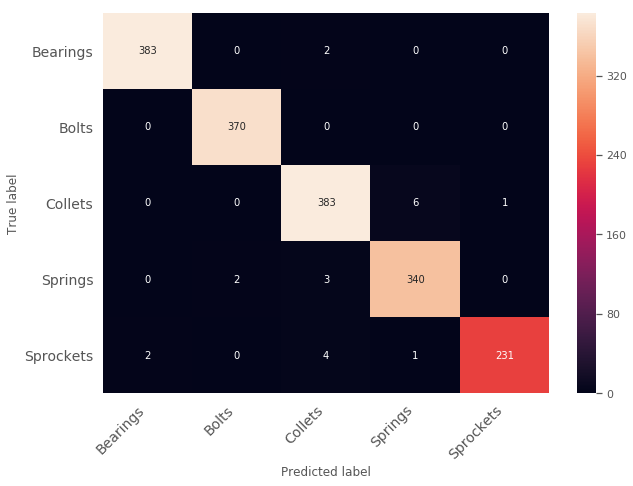

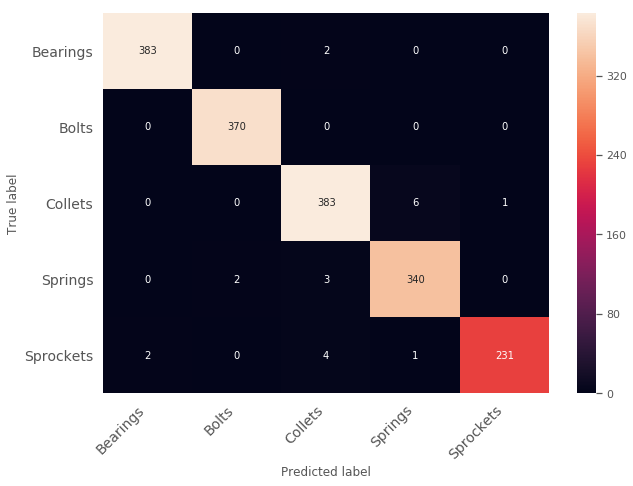

In [20]:
# print confusion matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(testy.argmax(axis=1),
                 preds.argmax(axis=1))

def print_confusion_matrix(confusion_matrix, class_names, figsize = (10,7), fontsize=14):

    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names, 
    )
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    return fig

print_confusion_matrix(cm, class_names=label_names)